# Assignment 4 - OSMnx

## Overview 

In this assignment we'll explore the street map of Natal - RN looking for insights concerning the time response of fire events and the size of a search perimeter for bank robbery. We will establish the area of the city covered by the First Groupement of Military Firefighters and São Gonçalo do Amarante's Firefighters Unit within five minutes after team mobilization. We'll also analyze the network of cycleways in the city and how a cyclist may feel about it.
We'll make extensive use of the shortest path algorithm even though it isn't directed called in order to find theses areas using the OSMnx library.

## Browse
* [Data](#data)
* [Points of Interest](#Points-of-Interest)
* [Fire incidents response](#fire-incident-response)
* [The Case of Cyclists' Isolation](#the-case-of-cyclists-isolation)

In [1]:
#!pip install osmnx

In [2]:
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import nxviz as nv
import geopandas as gpd

c:\Users\filip\AppData\Local\Programs\Python\Python311\Lib\site-packages\nxviz\__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.4 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.4, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


## Data

All analyses are going to be performed using the map of Natal. The fire stations coordinates were acquired using Google Maps and the speed limits were determined roughly based on the article 61 of the Brazilian Traffic Code.

In [14]:
# Get the graph of the city of Natal
N = ox.graph_from_place('Natal, Brazil', network_type='drive', retain_all=True)

response_time = 5 # minutes

# Set a list of colors for usage throughout the notebook
colors = list(mcolors.TABLEAU_COLORS.values())

# Get the nodes nearest to the fire stations
first_groupement = ox.distance.nearest_nodes(N, X=-35.20828267757094, Y=-5.804361075368305)
SGA_unit = ox.distance.nearest_nodes(N, X=-35.2911237630651, Y=-5.736734932191266)

# Set the speed limits for each category of road
speed_limits = {
    'residential': 40,
    'tertiary': 40,
    'secondary': 60,
    'primary': 60,
    'trunk': 80,
    'motorway': 80,
    'motorway_link': 80,
    'trunk_link': 80,
    'primary_link': 60,
    'secondary_link': 60,
    'tertiary_link': 40,
    'unclassified': 40,
    'unknown': 40
}



The following code cell adds a travel time to each edge based on its highway type and inferred speed limit, this metric is key for determining the reachable zone from the fire stations.

In [15]:
for _, _, data in N.edges(data=True):
    type_of_highway = data.get('highway', 'unknown')
    if isinstance(type_of_highway, list):
        max_speed = 0
        for type_ in type_of_highway:
            if type_ in speed_limits.keys():
                max_speed = max(max_speed, speed_limits[type_])
        data['time'] = data['length'] / (max_speed*1000/60)
    elif type_of_highway in speed_limits.keys():
        data['time'] = data['length'] / (speed_limits[type_of_highway]*1000/60)


## Fire Incident Response

Hereby we'll focus on visualizing on the map the region the fire stations in Natal can cover within 5 minutes after the call. In order to achieve this visualization, we made two ego subgraph centered around the firefighters' bases of operation and limiting its sizes to only those nodes with shortest paths of less than or equal to five minutes, based on the speed limits imposed on said path. For this study we don't consider traffic conditions and/or speeding regulation for emergency vehicles.

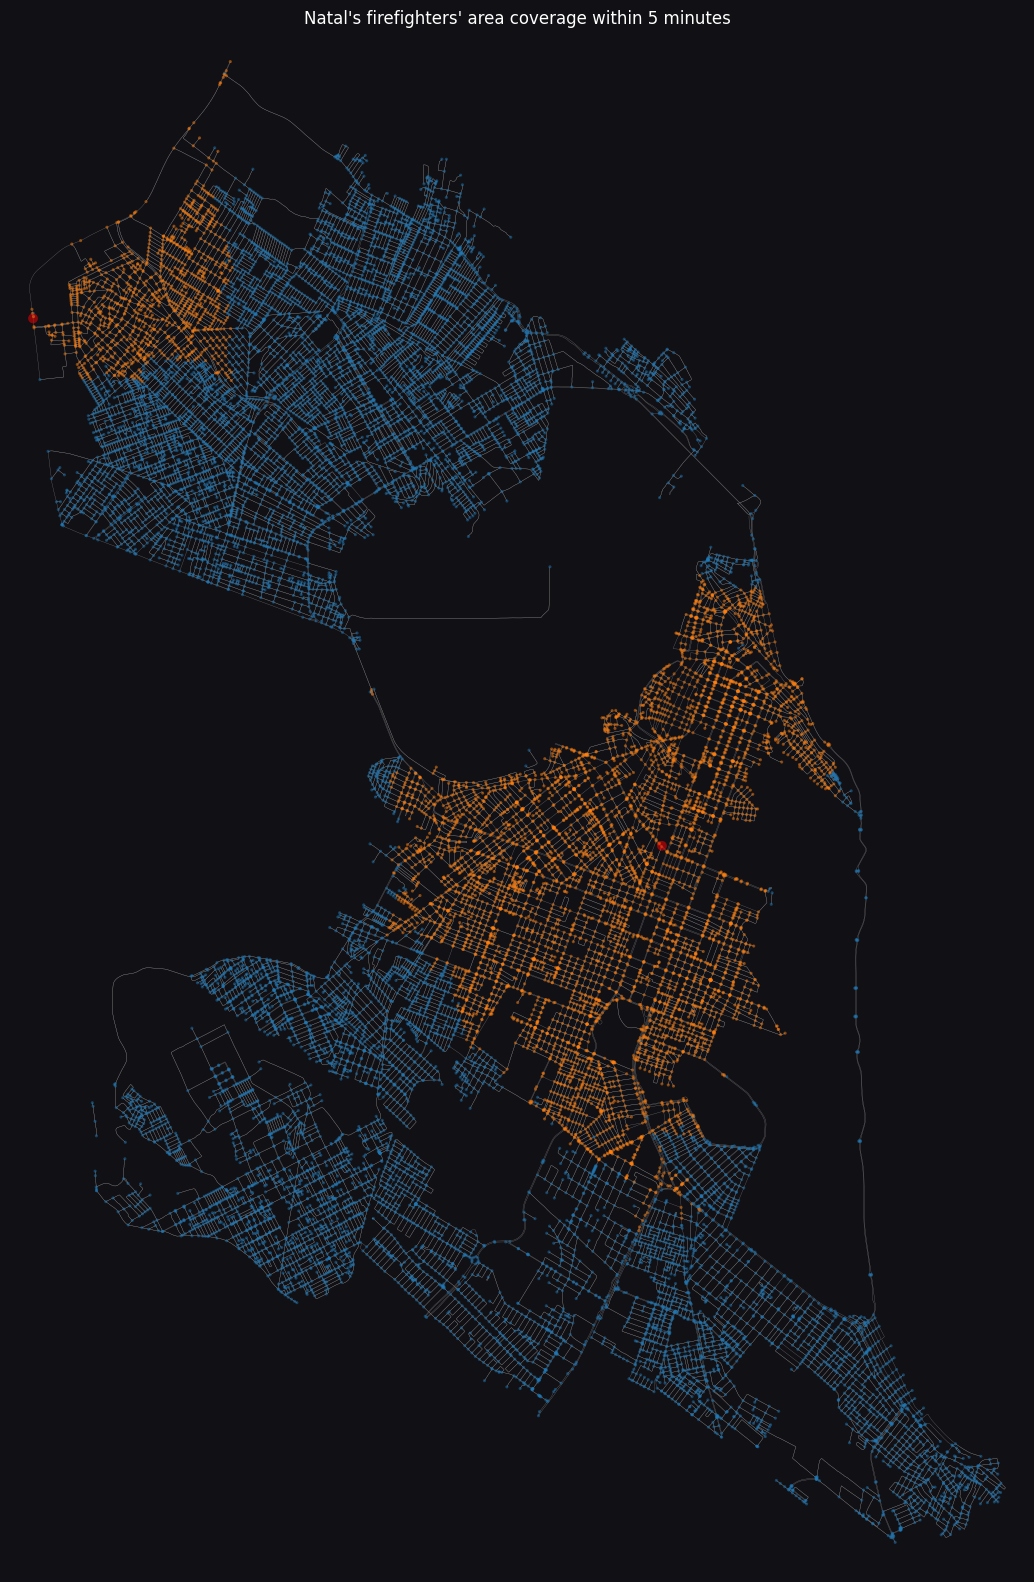

In [25]:
node_colors = {} # Create a dictionary to store the colors of the nodes for the plot

# The radius parameter in the ego_graph function uses the shortest path distance based on the 'time' attribute to calculate the time it takes 
# to reach the nodes and therefore filter out those that are not reachable within the response time
first_groupement_coverage = nx.ego_graph(N, first_groupement, radius=response_time, distance="time")
SGA_unit_coverage = nx.ego_graph(N, SGA_unit, radius=response_time, distance="time")

for node in first_groupement_coverage.nodes() | SGA_unit_coverage.nodes():
    node_colors[node] = colors[1]
# Set the color of the fire stations to red
node_colors[first_groupement] = 'r'
node_colors[SGA_unit] = 'r'

nc = [node_colors[node] if node in node_colors else colors[0] for node in N.nodes()]
ns = [50 if node in [first_groupement, SGA_unit] else 5 for node in N.nodes()]

fig, ax = plt.subplots(figsize=(25, 20), facecolor="#101015")
ax.set_title("Natal's firefighters' area coverage within 5 minutes", {"color": 'w'})
ax.set_facecolor("#101015")

ox.plot_graph(
    N,
    ax=ax,
    node_color=nc,
    node_size=ns,
    node_alpha=0.5,
    edge_linewidth=0.2,
    edge_color= colors[7],
)

plt.show()

We can see that the green area is small compared with the city size, we can roughly calculate the portion of the city covered by using area of the convex hull that encompass the nodes in each relevant graph.

In [ ]:
N_gdf = ox.graph_to_gdfs(ox.project_graph(N), edges=False)
first_groupement_coverage_gdf = ox.graph_to_gdfs(ox.project_graph(first_groupement_coverage), edges=False)
SGA_unit_coverage_gdf = ox.graph_to_gdfs(ox.project_graph(SGA_unit_coverage), edges=False)

N_area = N_gdf.unary_union.convex_hull.area
first_groupement_coverage_area = first_groupement_coverage_gdf.unary_union.convex_hull.area
SGA_unit_coverage_area = SGA_unit_coverage_gdf.unary_union.convex_hull.area

five_minute_area_coverage = (first_groupement_coverage_area+SGA_unit_coverage_area)/N_area*100

print(f"The fire stations can only cover {five_minute_area_coverage:.2f}% of the city of Natal within 5 minutes")

The fire stations cover only 26.61% of the city of Natal within 5 minutes


Further exploration of this result could be done by crossing this map with demographic data in order to find how well served the city's population is rather the the area only and what could be a suitable location for a third or fourth fire station to help increase the level of service to the population, since the longer the time to control a fire the lesser the chance of it not reaching flashover.

## The Case of Cyclists' Isolation

For this one we'll discuss how the network of cycleways in the city of Natal is connected. For this we'll filter the edges marked as cycleways on the OSM data and make a subgraph of it. Then we'll color the connected components and extract some metrics of them to have some insights on how a cyclist or a hobby cyclist may feel moving around the city.

In [ ]:
C = ox.graph_from_place('Natal, Brazil', network_type='bike', retain_all=True)

nodes_in_cycleway = set()
for u, v, data in C.edges(data=True):
    if 'cycleway' in data.get('highway', ''):
        nodes_in_cycleway.add(u)
        nodes_in_cycleway.add(v)

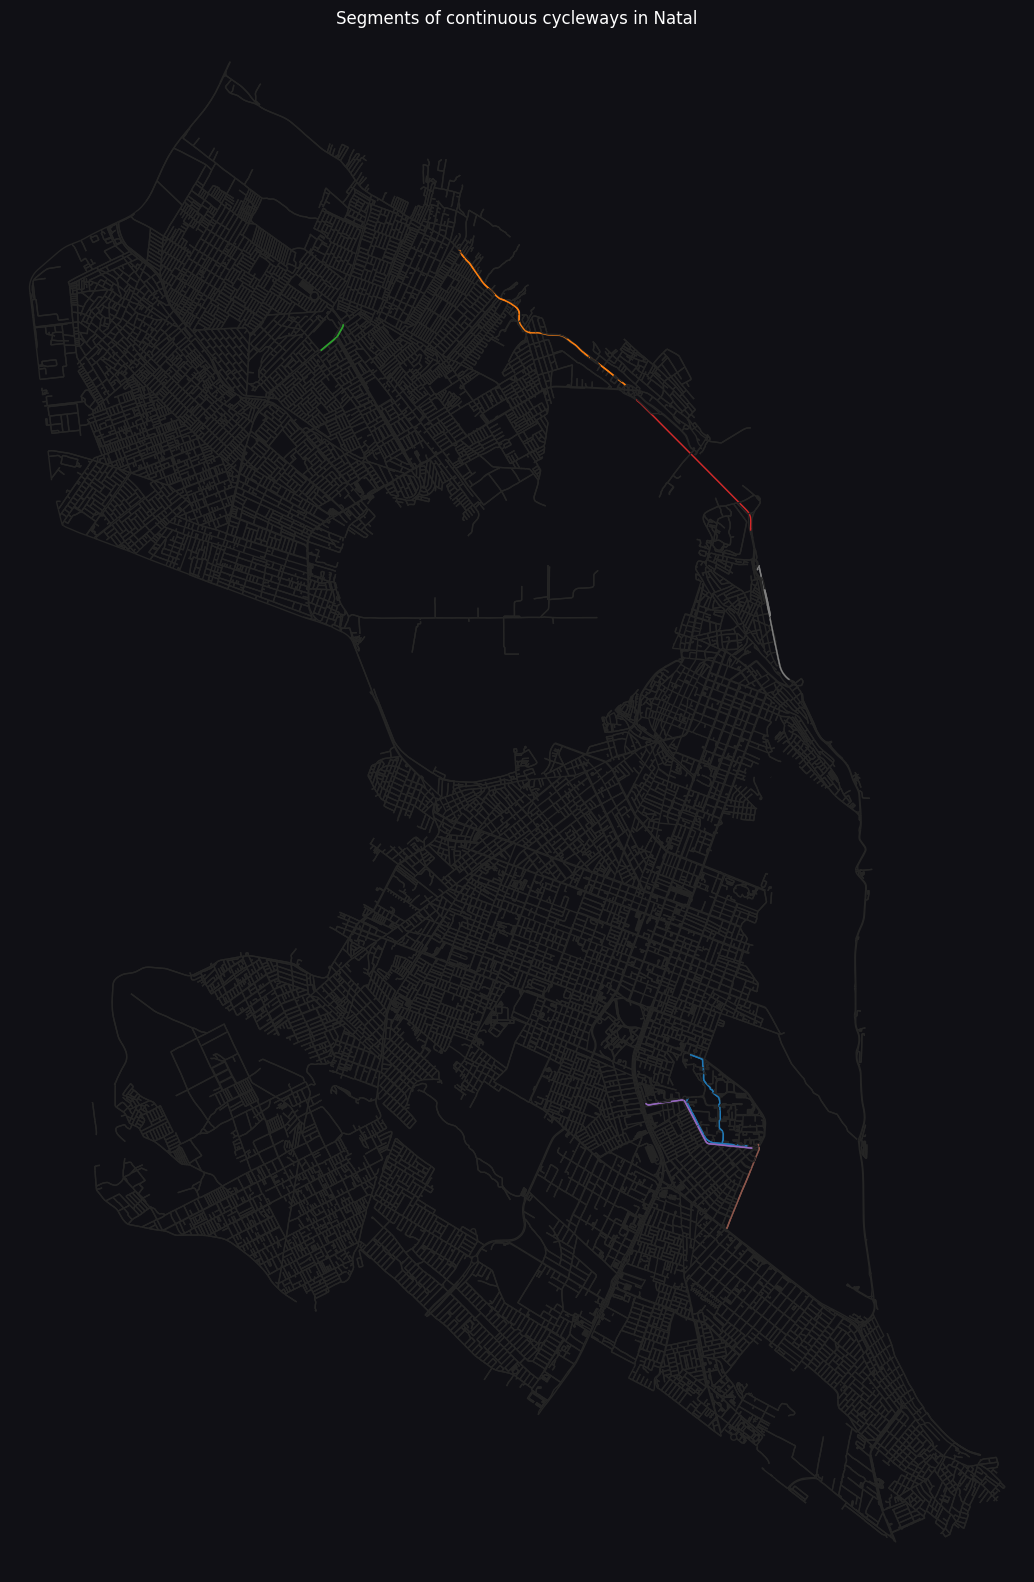

In [ ]:
# Get the subgraph of the cycleway and convert it to an undirected graph to calculate the connected components in it
A = nx.subgraph(C, nodes_in_cycleway).to_undirected()

# Remove self-loops as they are confusing in this context
A.remove_edges_from(nx.selfloop_edges(A))
n_conn_components = nx.number_connected_components(A)

# Metrics for the cycleways
avg_radius = 0
total_cycles_in_cycleways = 0

for i, component in enumerate(nx.connected_components(A)):
    # Calculate the metrics
    B = nx.Graph()
    B.add_edges_from(nx.subgraph(A, component).edges())
    total_cycles_in_cycleways += len(nx.cycle_basis(B))
    avg_radius += nx.radius(nx.subgraph(A, component), weight='length')/n_conn_components
    
    # Assign a unique color to each connected component
    color = colors[i % len(colors)]
    for u, v, data in nx.subgraph(C, component).edges(data=True):
        data['color'] = color

# Plot the graph showing the connected components in different colors
figs, ax = plt.subplots(figsize=(25, 20), facecolor="#101015")
ax.set_facecolor("#101015")
ax.set_title("Segments of continuous cycleways in Natal", {"color": 'w'})
ox.plot_graph(C, ax=ax, node_size=0, edge_color=[data.get('color', '#252525') for _, _, data in C.edges(data=True)])
plt.show()

In [9]:
print(f'Natal cycleways network has {n_conn_components} isolated continuous sections that on average have an average radius of {avg_radius:.2f}m and a total of {total_cycles_in_cycleways} cycles.')

Natal cycleways network has 8 isolated continuous sections that on average have an average radius of 1126.68m and a total of 0 cycles.


For the analysis above, we could argue that traveling by bike in Natal is quite limited if you are not willing to deal with regular traffic. The connected components virtually form only two zones and they are far away form each other. Besides, the regions in which they are situated aren't let's say work-commute friendly. The lack of mode integration with public transportation kind of makes the UFRN's network a zone for cyclists living in the vicinity of the university only. The other big region crosses the bridge and have a great view of the sea, but in my opinion, the lack of cycles forces the cyclists to return using the same way they came and this may diminish the overall experience.